# Machine Learning Model Implementations
This file includes machine learning model implementations and optimization steps.
The models used in order is as follows:
1. KNN classifier
2. ...


### Import Packages and Load Dataset

Labels come from 2 different PSG systems: Remlogic and Somnomedics. Sleep stage labels are as follows:

0 = Awake = SLEEP-S0 \
1 = REM   = SLEEP-REM \
2 = Light = SLEEP-S1 and  SLEEP-S2 \
3 = Deep  = SLEEP-S3 

EMFIT is the piezoelectric mat and Somnofy is the radar.

In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
# i put the following in results.py:
#from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import CategoricalNB

import numpy as np
from loader import *
from plot import *
from results import *

In [2]:
subjectID = PARTICIPANT_IDS[1]
sleep_stages = read_patient_data(subjectID)

In [3]:
labels = sleep_stages["sleep_stage_num_psg"]
features = sleep_stages.drop(columns="sleep_stage_num_psg")
size = sleep_stages.shape[0]
divide_ind = int(size*.7)

In [4]:
print("Radar: ", balanced_accuracy_score( labels[:divide_ind], sleep_stages["sleep_stage_num_somnofy"][:divide_ind]))
print("Mat: ", balanced_accuracy_score( labels[:divide_ind], sleep_stages["sleep_stage_num_emfit"][:divide_ind]))

Radar:  0.45474044012102816
Mat:  0.5013282629573407


<AxesSubplot:xlabel='timestamp_local'>

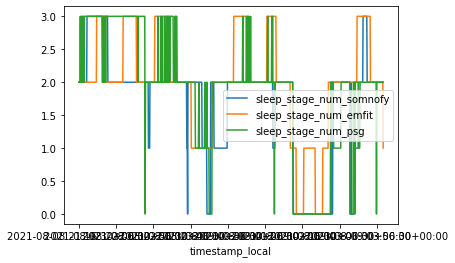

In [5]:
sleep_stages.plot()

In [6]:
x_tr, y_tr = features[:divide_ind], labels[:divide_ind]
x_te, y_te = features[divide_ind:], labels[divide_ind:]

### KNN Classifier

In [7]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(x_tr, y_tr)

KNeighborsClassifier(n_neighbors=7)

In [8]:
preds = knn_classifier.predict(x_te)

0.22324159021406728
[[0.         0.44308943 0.01626016 0.        ]
 [0.         0.         0.08130081 0.01626016]
 [0.         0.03252033 0.29674797 0.11382114]
 [0.         0.         0.         0.        ]]


/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


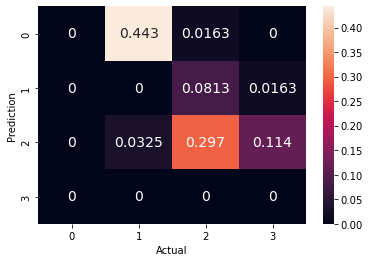

In [9]:
# Accuracy score 
print(balanced_accuracy_score( y_te, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te, normalize = True)
# print(classification_report( y_te, preds))

### Naive Bayes 

In [10]:
cnb_classifier = CategoricalNB()
cnb_classifier.fit(x_tr, y_tr)

CategoricalNB()

In [11]:
preds = cnb_classifier.predict(x_te)

0.41768828989743173
[[0.16260163 0.22357724 0.07317073 0.        ]
 [0.         0.         0.09756098 0.        ]
 [0.         0.         0.39837398 0.04471545]
 [0.         0.         0.         0.        ]]


/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


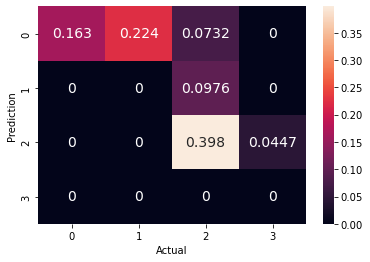

In [12]:
# Accuracy score 
print(balanced_accuracy_score( y_te, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te, normalize = True)
# print(classification_report( y_te, preds))

### Overall Balanced accuracy


In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    overall_balanced_accuracy()

Radar:   Acc =  0.5933742461892262 St. Dv. =  0.17976279835951414
Mat:   Acc =  0.3697276168296211 St. Dv. =  0.10357674967087531
kNN:   Acc =  0.42770152321353216 St. Dv. =  0.14663659957629682
NB:   Acc =  0.4777296080334432 St. Dv. =  0.1616148127294011
